# Práctica 1: LiDAR Clustering



## Índice

1. Integrantes del equipo

2. Librerías

3. Carga de Datos <br>

    3.1. Dataset vehículos

4. Clustering DBSCAN


## Integrantes del equipo

* Alejandro Cortijo Benito
* Alejandro García Mota

Este notebook tiene buscamos hacer `clustering` y `tracking` a los vehículos que aparecen en las muestras recogidas con el LiDAR. 

## <a id='imports'></a>Librerias

In [5]:
# Procesamiento de datos
import os
import cv2
import numpy as np
import pandas as pd

# Clustering
from sklearn.cluster import DBSCAN

# Visualización de datos
from tqdm import tqdm
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from PIL import Image
from IPython.display import display, Image as IPImage

## <a id='dataset'></a>Carga de datos

### Dataset vehículos

Cargamos todos los frames del dataset original ordenamos para evitar inconsistencias en los datos.

In [2]:
# Definir el directorio donde se encuentran los archivos CSV
directory = './data/pointclouds/'

def extract_timestamp_and_id(filename):
    parts = filename.replace('pointcloud_', '').replace('.csv', '').split('_')
    timestamp = int(parts[0])  # Primer número (timestamp grande)
    identifier = int(parts[1])  # Segundo número (ID más pequeño)
    return (timestamp, identifier)

dataframes = []


for filename in sorted(os.listdir(directory), key=extract_timestamp_and_id):
    if filename.endswith('.csv'):  # Comprobar si el archivo es un CSV
        file_path = os.path.join(directory, filename)
        df = pd.read_csv(file_path)  # Cargar el CSV en un DataFrame
        dataframes.append(df)  # Añadir el DataFrame a la lista

Usando los conocimientos de `LiDAR_Clustering` procedemos a clusterizar cada frame por separado, hemos decidio usar **DBSCAN** ya que a priori desconocemos el número de de vehículos. Por otro lado, para identificar si los vehículos que salen en escena son los mismos que en el frame anterior vamos a usar la diferencia entre los centroides para computar si el vehivulo del instante `t-1` es el mismo o no. 

In [3]:
def calculate_eculidean_distance(centroid, other):
    return np.sqrt((centroid[0] - other[0])**2 + (centroid[1] - other[1])**2 + (centroid[2] - other[2])**2)

def get_cluster(last_centroids, center_x, center_y, center_z):

    # Si no hay centroides, se inicializa el primer clúster con el punto actual.
    if len(last_centroids) == 0:
        last_centroids[0] = [center_x, center_y, center_z]
        return 0
    
    max_distance = 4 # Distancia máxima para considerar que el punto pertenece a un clúster existente.

    # Calcula las distancias desde el nuevo punto a cada centroide existente.
    distances = {cluster: calculate_eculidean_distance([center_x, center_y, center_z], centroid)
                 for cluster, centroid in last_centroids.items()}
    
    # Encuentra el clúster más cercano basado en la distancia calculada.
    closest_cluster = min(distances, key=distances.get)

    # Si la distancia al clúster más cercano es menor que la distancia máxima, actualiza el centroide.
    if distances[closest_cluster] < max_distance:
        last_centroids[closest_cluster] = [center_x, center_y, center_z]
        return closest_cluster
    
    # Si la distancia es mayor que la máxima, crea un nuevo clúster.
    new_cluster_id = max(last_centroids.keys()) + 1
    last_centroids[new_cluster_id] = [center_x, center_y, center_z]
    return new_cluster_id

In [4]:
centroids = []
last_centroids = {}
output_dir = 'frames'  # Carpeta para guardar las imágenes
os.makedirs(output_dir, exist_ok=True)  # Crea el directorio si no existe

for i, frame in enumerate(tqdm(dataframes)):
    X = frame[['x', 'y', 'z']]

    dbscan = DBSCAN(eps=3, min_samples=23, n_jobs=-1)

    y_dbscan = dbscan.fit_predict(X)

    df_clustered = X.copy()
    df_clustered['cluster'] = y_dbscan

    # Borrar ruido
    df_clustered = df_clustered[df_clustered['cluster'] != -1]

    fig = px.scatter(df_clustered, x='x', y='y', color='cluster')

    df_result = pd.DataFrame()
    df_result['x'] = df_clustered['x']
    df_result['y'] = df_clustered['y']
    df_result['z'] = df_clustered['z']
    df_result['cluster'] = df_clustered['cluster']
    df_result['clusterId'] = -1

    # Calcular bounding boxes para cada cluster
    bounding_boxes = {}

    clusters_count = np.array(y_dbscan).max() + 1
    for cluster in range(clusters_count):
        cluster_points = df_result[df_result['cluster'] == cluster]
        min_x, max_x = cluster_points['x'].min(), cluster_points['x'].max()
        min_y, max_y = cluster_points['y'].min(), cluster_points['y'].max()
        min_z, max_z = cluster_points['z'].min(), cluster_points['z'].max()

        # Calcular el centro
        center_x = (min_x + max_x) / 2
        center_y = (min_y + max_y) / 2
        center_z = (min_z + max_z) / 2

        clusterId = get_cluster(last_centroids, center_x, center_y, center_z)
        centroids.append((clusterId, center_x, center_y, center_z))

        df_result.loc[df_result['cluster'] == cluster, 'clusterId'] = clusterId
        bounding_boxes[clusterId] = {
            'min_x': min_x, 'max_x': max_x,
            'min_y': min_y, 'max_y': max_y,
            'min_z': min_z, 'max_z': max_z
        }

    fig = go.Figure()

    # Añadir datos
    fig.add_trace(go.Scatter3d(
        x=df_result['x'],
        y=df_result['y'],
        z=df_result['z'],
        mode='markers',
        marker=dict(
            color=df_result['clusterId'],
            colorscale='Viridis',
            size=3,
            cmin=0,
            cmax=10,
            opacity=0.5
        ),
        name='Data Points'
    ))

    # Añadir bounding boxes
    for cluster, bbox in bounding_boxes.items():
        fig.add_trace(go.Scatter3d(
            x=[bbox['min_x'], bbox['max_x'], bbox['max_x'], bbox['min_x'], bbox['min_x'], bbox['min_x'], bbox['max_x'], bbox['max_x'], bbox['min_x'], bbox['min_x'], bbox['max_x'], bbox['max_x'], bbox['max_x'], bbox['max_x'], bbox['min_x'], bbox['min_x'], bbox['min_x']],
            y=[bbox['min_y'], bbox['min_y'], bbox['max_y'], bbox['max_y'], bbox['min_y'], bbox['min_y'], bbox['min_y'], bbox['max_y'], bbox['max_y'], bbox['max_y'], bbox['max_y'], bbox['max_y'], bbox['min_y'], bbox['min_y'], bbox['min_y'], bbox['min_y'], bbox['max_y']],
            z=[bbox['min_z'], bbox['min_z'], bbox['min_z'], bbox['min_z'], bbox['min_z'], bbox['max_z'], bbox['max_z'], bbox['max_z'], bbox['max_z'], bbox['min_z'], bbox['min_z'], bbox['max_z'], bbox['max_z'], bbox['min_z'], bbox['min_z'], bbox['max_z'], bbox['max_z']],
            mode='lines',
            line=dict(color='red', width=3),  # Increase line width
            name=f'Vehiculo {cluster}'  # Improved naming
        ))

    # Añadir el centroide
    fig.add_trace(go.Scatter3d(
        x=[bbox['min_x'] + (bbox['max_x'] - bbox['min_x']) / 2 for bbox in bounding_boxes.values()],
        y=[bbox['min_y'] + (bbox['max_y'] - bbox['min_y']) / 2 for bbox in bounding_boxes.values()],
        z=[bbox['min_z'] + (bbox['max_z'] - bbox['min_z']) / 2 for bbox in bounding_boxes.values()],
        mode='markers',
        marker=dict(
            size=6,
            color='red',
            symbol='x'
        ),
        name='Centroids'
    ))


    # Dibujar las lineas conectandas a los centroides de cada cluster con diferentes colores
    colors = px.colors.qualitative.Dark24
    for cluster_id, centroid in last_centroids.items():
        cluster_centroids = [c for c in centroids if c[0] == cluster_id]
        if len(cluster_centroids) > 1:
            fig.add_trace(go.Scatter3d(
                x=[c[1] for c in cluster_centroids],
                y=[c[2] for c in cluster_centroids],
                z=[c[3] for c in cluster_centroids],
                mode='lines',
                line=dict(color=colors[cluster_id % len(colors)], width=2),
                name=f'Cluster {cluster_id} Path',
                showlegend=False
            ))


    # Layout
    fig.update_layout(
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z',
            aspectmode='data',
            camera=dict(
                eye=dict(x=5, y=3, z=4)
            )
        ),
        title='Carretera',
        legend=dict(title='Legend')
    )

    fig.write_image(os.path.join(output_dir, f'frame_{i}.png'))


100%|██████████| 369/369 [17:24<00:00,  2.83s/it]


Una vez tenemos todos los frames computados procedemos a unificarlos en un único video `tracking.mp4`.

In [5]:
image_folder = './frames/'   # Outputs celda anterior (tracking)
video_name = 'tracking.mp4'  # Nombre del video de salida

# Función para extraer el número de las imágenes
def extract_frame_number(filename):
    return int(filename.replace('frame_', '').replace('.png', '').replace('.jpg', ''))

# Obtener y ordenar todas las imágenes de la carpeta
images = [img for img in os.listdir(image_folder) if img.endswith(".jpg") or img.endswith(".png")]
images = sorted(images, key=extract_frame_number)

first_image = cv2.imread(os.path.join(image_folder, images[0]))

# Ajustar la resolución
desired_width, desired_height = 640, 480
first_image_resized = cv2.resize(first_image, (desired_width, desired_height))
height, width, layers = first_image_resized.shape

# Definir el codec y crear el objeto VideoWriter con 30 FPS
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec compatible con macOS
video = cv2.VideoWriter(video_name, fourcc, 4, (width, height))

# Añadir cada imagen al video
for image in images:
    img = cv2.imread(os.path.join(image_folder, image))
    img_resized = cv2.resize(img, (desired_width, desired_height))  # Redimensionar cada imagen
    video.write(img_resized)

# Liberar el objeto VideoWriter
video.release()
cv2.destroyAllWindows()

print(video_name+" creado con éxito.")

tracking.mp4 creado con éxito.


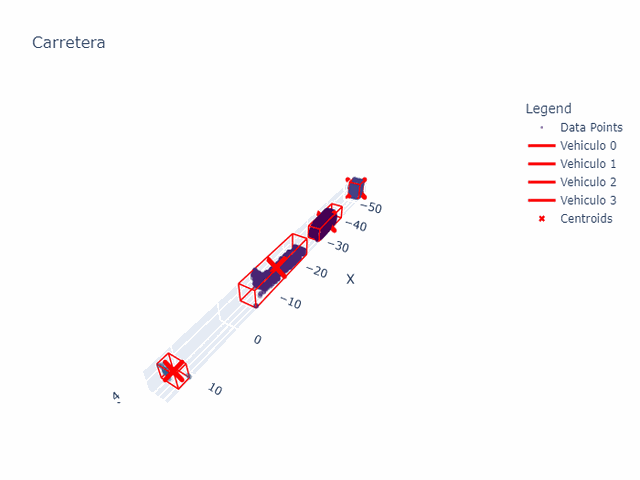

In [10]:
# Carpeta de imágenes y nombre del archivo de salida
image_folder = './frames/'  
gif_name = 'tracking.gif'   

# Función para extraer el número de las imágenes
def extract_frame_number(filename):
    return int(filename.replace('frame_', '').replace('.png', '').replace('.jpg', ''))

# Obtener y ordenar todas las imágenes de la carpeta
images = [img for img in os.listdir(image_folder) if img.endswith(".jpg") or img.endswith(".png")]
images = sorted(images, key=extract_frame_number)

# Lista para almacenar las imágenes
frames = []

# Abrir y redimensionar cada imagen
desired_width, desired_height = 640, 480
for image in images:
    img = Image.open(os.path.join(image_folder, image))
    img_resized = img.resize((desired_width, desired_height), Image.Resampling.LANCZOS)  # Redimensionar cada imagen
    frames.append(img_resized)

# Guardar las imágenes como un GIF animado
frames[0].save(gif_name, format='GIF', append_images=frames[1:], save_all=True, duration=250, loop=0)

with open(gif_name, 'rb') as f:
    display(IPImage(f.read(), format='gif'))

El gif muestra el movimiento de los camiones por una carretera. Po un lado cada camión se identifica siempre con el mismo Id, representado por el color. Además, sobre cada cluster, o vehículo, se dibuja su correspondiente bounding box, el centro de dicha bounding box, y la línea que representa su trayectoría anterior. Esta trayectoría es la sucesión de las posiciones del centro de la bounding box.